# Imports
Imports necesarios para correr el notebook

In [1]:
import pandas as pd, spacy, math, os
import matplotlib.pyplot as plt

from datetime import datetime
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud

# Cargar modelos de Spacy
Se agregó como hiperparámetro el modelo de spacy, por lo que se pre-cargaron 4 modelos diferentes de spacy para hacer pruebas al variar el modelo

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

stw = stopwords.words('english')
stw.extend(['retrieve', 'retrieved', 'isbn', 'pmid','archived','th'])
STOPWORDS = set(stw)

In [3]:
ALLOWED_POSTAGS = ['NOUN', 'ADJ', 'VERB', 'ADV', 'PART']
NLP_MODELS = {
    'en_core_web_trf': spacy.load('en_core_web_trf'),    
    'en_core_web_sm': spacy.load('en_core_web_sm'),
    'en_core_web_md': spacy.load('en_core_web_md'),
    'en_core_web_lg': spacy.load('en_core_web_lg')
}

# Clase Model
Se definió una clase model que recibe los hiperparámetros con los que se puede entrenar el modelo. Se tomó de base la clase de Modelo utilizado en la tarea anterior.

In [4]:
class Model:
    # not necesarry but just as a 'fyi'
    raw_data = [] # constructor
    stopwords = STOPWORDS # default if not given
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    debug_history = dict()
    ngram_model = None
    words = []
    nlp = None
    nlp_text = ''
    
    def __init__(self, df, steps
                 , num_topics=10
                 , nlp_model = 'en_core_web_lg'
                 , stopwords=STOPWORDS
                 , ngrams=2
                 , min_count=5
                 , threshold=10
                 , allowed_postags=ALLOWED_POSTAGS
                 , debug = False
                 , random_state=100
                 , update_every=1
                 , chunksize=100
                 , passes=10
                 , alpha='auto'
                 , per_word_topics=True
        ):
        self.steps = steps
        self.stopwords = stopwords
        self.num_topics = num_topics
        self.raw_data = df
        self.ngram = {'min_count': min_count, 'threshold': threshold, 'ngrams': ngrams}
        self.lda_model_params = {'random_state': random_state, 'update_every': update_every, 'chunksize': chunksize, 'passes': passes, 'alpha': alpha, 'per_word_topics': per_word_topics}
        self.allowed_postags = allowed_postags
        self.debug = debug
        self.nlp_text = nlp_model
        if nlp_model not in NLP_MODELS:
            nlp_model = 'en_core_web_lg'
        self.nlp = NLP_MODELS[nlp_model]
        
    def preprocess(self, raw_data, print_steps=True):
        if print_steps:
            print(f'{datetime.now()}    sentences_as_words')
        result = self.sentences2words(raw_data)
        # iterate the pipeline
        for step in self.steps:
            if print_steps:
                print(f'{datetime.now()}    {step}')
            
            if step == 'remove_stopwords':
                result = self.remove_stopwords(result)
            elif step == 'lemmatization':
                result = self.lemmatization(result)
            elif step == 'ngram':
                # train ngram model
                ngram_model = self.train_ngrams(result, ngrams=self.ngram['ngrams'], min_count=self.ngram['min_count'], threshold=self.ngram['threshold'])

                if len(ngram_model)>0:
                    self.ngram_model = ngram_model

                    # apply ngram model
                    result = self.create_ngrams(ngram_model, result)
                else:
                    print(f'{datetime.now()} ngram not done: {self.ngram["ngram"]}')
            else:
                print(f'{datetime.now()} instruction not found: {step}')
        return result
        
    
    def fit(self, preprocess_data = None):
        
        print(f'{datetime.now()}  start')
        
        if preprocess_data == None:
            result = self.preprocess(self.raw_data)
        else:
            print(f'{datetime.now()}    using preprocess data')
            result = preprocess_data
        
        # save words in a 1d array
        words = self.array2dto1d(result)
        if (self.debug):
            self.debug_history['words'] = words
        
        # build dictionary
        dictionary = Dictionary([words])
        self.dictionary = dictionary
        
        # calculate corpus as an array of bag of words
        corpus = [dictionary.doc2bow(text) for text in result]
        if (self.debug):
            self.debug_history['corpus'] = corpus
            
        print(f'{datetime.now()}    creating model')
        
        # train LDA Model
        self.lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=self.num_topics, 
            per_word_topics=self.lda_model_params['per_word_topics'],
            random_state=self.lda_model_params['random_state'],
            update_every=self.lda_model_params['update_every'],
            chunksize=self.lda_model_params['chunksize'],
            passes=self.lda_model_params['passes'],
            alpha=self.lda_model_params['alpha']
        )
        
        print(f'{datetime.now()}  end')
        
    def predict_list(self, list_of_sentences, debug=False, coherence='c_v', topn=20):
        results = []
        for sentence in list_of_sentences:
            results.append({'sentence': sentence, **self.predict(sentence, debug)})
            
        corpus = [self.dictionary.doc2bow(text['sentence_array']) for text in results]
        texts = [text['sentence_array'] for text in results]
                    
        # Coherence model
        coherence_model = CoherenceModel(
            model=self.lda_model
#             , corpus=corpus
            , texts=texts
            , dictionary=self.dictionary
            , coherence=coherence
            , topn=topn
        )
        return {'results': results, 'coherence_model': coherence_model}
    
    
    def predict(self, sentence, debug=False):
        """returns document topics"""
        sentences = [sentence]
        
        result = self.preprocess(sentences, print_steps=False)
        
        words_bow = self.dictionary.doc2bow(result[0])
    
        # keep only known words
        # sentence_array = [word for word in result[0] if self.dictionary.doc2idx([word])[0] != -1 ]
        sentence_array = result[0]
        return {
            'sentence_array': sentence_array
            # , 'bow': words_bow
            , 'topics': self.lda_model.get_document_topics(words_bow)
        }
    
    def get_coherence_model(self, list_of_sentences, debug=False, coherence='c_v', topn=10):
        
        result = self.preprocess(list_of_sentences, print_steps=False)
        
        # Coherence model
        coherence_model = CoherenceModel(
            model=self.lda_model
            , texts=result
            , dictionary=self.dictionary
            , coherence=coherence
            , topn=topn
        )
        return coherence_model
    
    def sentences2words(self, sentences):
        """
        receives a list of strings (sentences) ['hello world', 'test, sentence!'] 
        and returns for each sentence a split of its words: [['hello','world'], ['test','sentence']]
        using gensim simple_preprocess function
        """
        words = []
        for sentence in sentences:
            words.append(simple_preprocess(sentence, deacc=True))
        return words
        
    def remove_stopwords(self, list_of_list_of_words):
        """
        receives a list of list of words [['abc', 'abc', ...], ...]
        """
        words = []
        for sentence_as_words in list_of_list_of_words:
            words.append([word for word in sentence_as_words if word not in self.stopwords])
        return words
            
    def lemmatization(self, list_of_list_of_words):
        """
        receives a list of list of words [['swimming','after','playing']]
        and returns the same list with each words lemma: [['swim','after','play']]
        """
        words = []        
        for sentence_as_words in list_of_list_of_words:
            doc = self.nlp(' '.join(sentence_as_words))
            words.append([token.lemma_ for token in doc if token.pos_ in self.allowed_postags ])
        return words
    
    def array2dto1d(self, array2d):
        """
        receives a list of list of words [['hello','world'],['test']] 
        and returns in a single list ['hello','world','test']
        """
        result = []
        for array1d in array2d:
            result.extend(array1d)
        return result
            
    def train_ngrams(self, list_of_list_of_words, ngrams=2, min_count=5, threshold=10):
        if ngrams < 2:
            ngrams = 2
        result = list_of_list_of_words
        ngram_models = []
        for i in range(ngrams-1):
            ngram_phraser = Phrases(result, min_count=min_count, threshold=threshold)
            ngram_model = Phraser(ngram_phraser)
            ngram_models.append(ngram_model)
            result = list(ngram_model[result])
            
        return ngram_models
    
    def create_ngrams(self, ngram_model_array, list_of_list_of_words):
        """ngram_model = []"""
        result = list_of_list_of_words
        for ngram_model in ngram_model_array:
            result = list(ngram_model[result])
        return result        

# Word Cloud
Se definió una función para graficar un word cloud de cada tópico obtenido por el modelo.

In [5]:
def plot_cloud(model, export=False):
    topics_array = model.lda_model.get_topics()
    columns = 2
    rows = math.ceil(len(topics_array)/columns)
    
    fig, ax = plt.subplots(rows, columns, figsize = (18, 20))
    ax = ax.ravel()
    
    for topic_i in range(len(topics_array)):
        topic = topics_array[topic_i]
        wordcloud_text = {model.dictionary[i] : topic[i] for i in range(len(topic))} # i has the index of the dictionary
        # {'palabra': weight}
        
        # Generate wordcloud
        wordcloud = WordCloud(
            width = 400
            , height = 200
            , background_color='white'
            , margin=2
        )

        wordcloud.fit_words(wordcloud_text)
     
        ax[topic_i].imshow(wordcloud)
        ax[topic_i].set_title(f'Topic {topic_i}')
        ax[topic_i].set_axis_off()
        
        if (export):
            # export as image
            wordcloud.to_file(f'images/topic_{topic_i}.png')
    plt.show()

# Carga de datos
El dataset tokens_topics se construyó con un proceso en scrapy en el que se partió de un tópico en específico, el cual fue guardado en una columna en el CSV. Cada fila corresponde a un artículo de wikipedia que surgió del tópico base

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
validation = pd.read_csv('data/validation.csv')

In [7]:
train

,topic,title,text
0,art,Figurae,This article needs additional citations for ve...
1,sports,Sports league,Group of sports teams or individual athletes t...
2,food,Nutritional anthropology,Field of study. This article has multiple issu...
3,technology,Lithic reduction,Process of fashioning stones or rocks into too...
4,technology,Input/output,Communication between an information processin...
...,...,...,...
386,geography,Interaction,Phenomenon in which two or more objects have a...
387,art,Islamic art,Visual art forms associated with Muslims. This...
388,sports,FIBA AmeriCup,Men's basketball tournament. For the women's t...
389,geography,Aerial photography,Taking images of the ground from the air. An a...


Cantidad de artículos por tópico

In [8]:
train.groupby(['topic'])['topic'].count()

topic
art           63
food          42
geography     54
history       31
music         62
science       46
sports        45
technology    48
Name: topic, dtype: int64

In [9]:
test

,topic,title,text
0,music,Pitch (music),Perceptual property in music ordering sounds f...
1,sports,F1 (disambiguation),For the Wikipedia F1 criterion for speedy dele...
2,sports,Council of Europe,International organisation founded in 1949. No...
3,science,Ethology,"Not to be confused with ethics, ethnology, eti..."
4,sports,Musselburgh Links,". Musselburgh Links, The Old Golf CourseOld St..."
...,...,...,...
465,technology,Useful art,Practical or technological skills and methods....
466,science,Faience,Tin-glazed pottery. For the architectural mate...
467,art,Modern art,Artistic works produced during the period exte...
468,sports,1904 Summer Olympics,"Multi-sport event in Saint Louis, Missouri, US..."


In [10]:
test.groupby(['topic'])['topic'].count()

topic
art           68
food          64
geography     76
history       27
music         59
science       30
sports        73
technology    73
Name: topic, dtype: int64

In [11]:
validation

,topic,title,text
0,music,Eighteenth Dynasty of Egypt,Dynasty of Egypt from c. 1550 to 1292 BCE. Eig...
1,art,List of postmodern critics,. This is a list of postmodern literary critic...
2,history,Oral tradition,Culture preserved and transmitted through spee...
3,art,Theodor W. Adorno,"German philosopher, sociologist, and communist..."
4,technology,Clothing,"Covering worn on the body. ""Outfit"" redirects ..."
...,...,...,...
112,art,Work of art,"For other uses, see Work of art (disambiguatio..."
113,science,Theoretical computer science,Subfield of computer science and mathematics. ...
114,food,Sucralose,". Sucralose. Names. IUPAC name. 1,6-Dichloro-1..."
115,sports,Chuiwan,This article relies largely or entirely on a s...


In [12]:
validation.groupby(['topic'])['topic'].count()

topic
art           15
food          17
geography     11
history       10
music         14
science       15
sports        18
technology    17
Name: topic, dtype: int64

# Ejemplo, Modelo de Prueba
Se entrena un modelo simple para hacer pruebas del flujo completo

In [13]:
model_test = Model(
    train.text.values.tolist()
    , ['remove_stopwords']
    , num_topics = 8
    , nlp_model = 'en_core_web_lg'
    , stopwords=STOPWORDS
    , ngrams=2
    , min_count=10
    , threshold=30
    , allowed_postags=ALLOWED_POSTAGS
    , debug = False
    ## lda_model params
    , random_state=100
    , update_every=1
    , chunksize=100
    , passes=10
    , alpha='auto'
    , per_word_topics=True
)

preprocess_data = model_test.preprocess(train.text.values.tolist())
model_test.fit(preprocess_data)

2022-07-14 02:02:39.794967    sentences_as_words
2022-07-14 02:02:48.653405    remove_stopwords
2022-07-14 02:02:49.044004  start
2022-07-14 02:02:49.044152    using preprocess data
2022-07-14 02:02:51.631362    creating model
2022-07-14 02:03:27.788244  end


Ver los **tópicos obtenidos**

In [14]:
model_test.lda_model.print_topics()

[(0,
  '0.019*"art" + 0.008*"de" + 0.007*"language" + 0.007*"german" + 0.006*"languages" + 0.006*"bolivia" + 0.006*"school" + 0.004*"french" + 0.004*"la" + 0.004*"modernism"'),
 (1,
  '0.009*"team" + 0.008*"one" + 0.008*"season" + 0.007*"formula" + 0.007*"grand" + 0.007*"prix" + 0.006*"championship" + 0.006*"world" + 0.006*"sports" + 0.006*"renault"'),
 (2,
  '0.007*"bronze" + 0.007*"art" + 0.007*"age" + 0.006*"stone" + 0.006*"cave" + 0.005*"paleolithic" + 0.005*"culture" + 0.004*"years" + 0.004*"early" + 0.004*"found"'),
 (3,
  '0.012*"science" + 0.011*"history" + 0.010*"theory" + 0.008*"social" + 0.007*"cultural" + 0.006*"research" + 0.006*"geography" + 0.006*"human" + 0.005*"studies" + 0.004*"study"'),
 (4,
  '0.008*"food" + 0.004*"doi" + 0.004*"may" + 0.004*"also" + 0.003*"used" + 0.003*"original" + 0.003*"water" + 0.003*"world" + 0.003*"use" + 0.003*"climate"'),
 (5,
  '0.018*"music" + 0.004*"also" + 0.004*"funk" + 0.004*"dance" + 0.004*"gamelan" + 0.003*"new" + 0.003*"used" + 0.0

Calcular la **coherencia del modelo** para la data de train

In [15]:
model_test.get_coherence_model(train['text'].values.tolist()).get_coherence()

0.545303116766466

Calcular la **coherencia del modelo para la data de validación**

In [16]:
model_test.get_coherence_model(validation['text'].values.tolist()).get_coherence()

0.4918408779862964

Graficar **word clouds de los tópicos** obtenidos

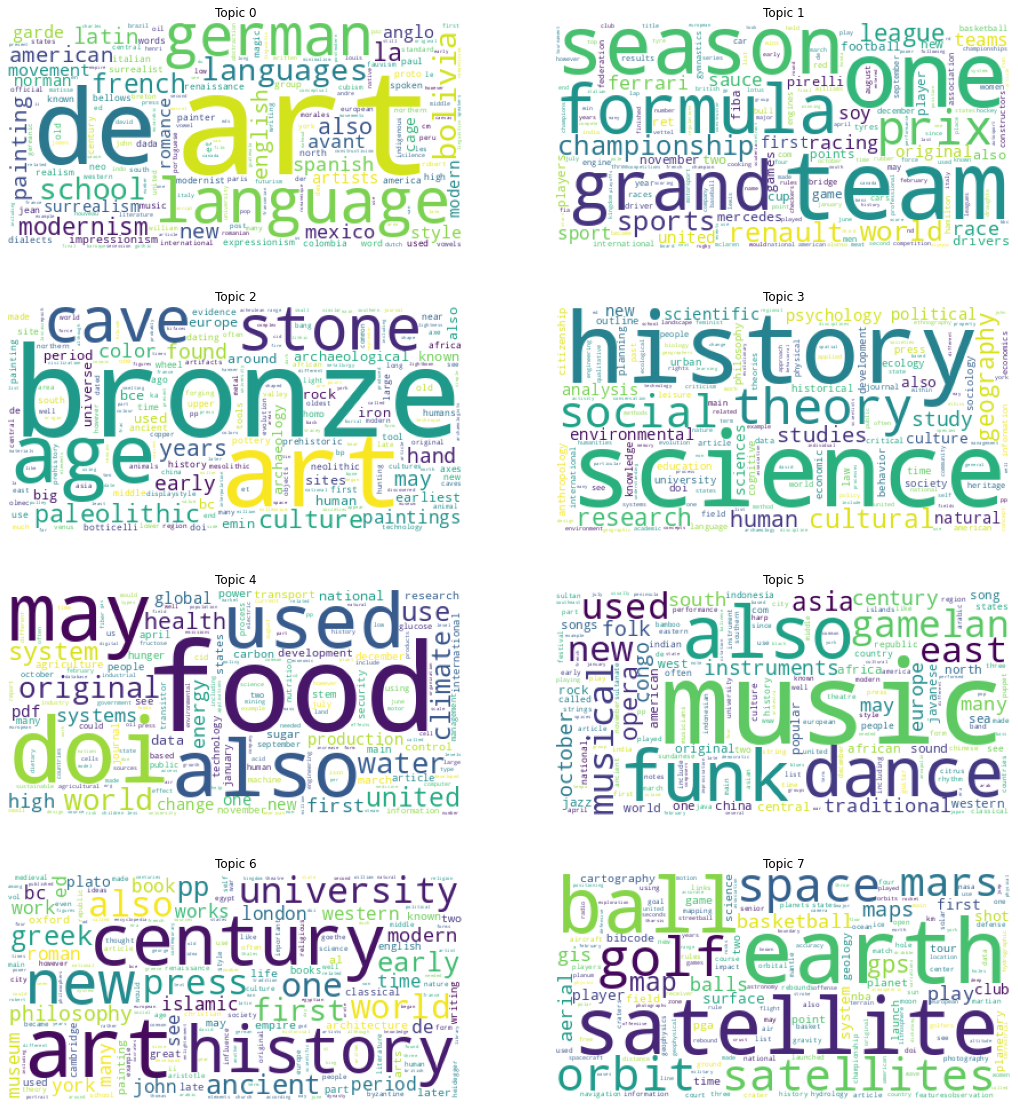

In [17]:
plot_cloud(model_test)

Prueba de **predict** con un artículo de deportes

In [18]:
sports_article = test[test['topic']=='sports'].iloc[3].text
sports_article

'Overview explanation of what constitutes a Formula One Grand Prix motor racing event. This article is about the racing events specifically. For a general overview of the sport, see Formula One. Formula One. Current season. 2022 Formula One World Championship. Related articles. History of Formula One. Formula One racing. Formula One regulations. Formula One cars. Formula One engines. Formula One tyres. Lists. Drivers (GP winnersPolesittersFastest laps ChampionsNumbers). Constructors (GP winnersChampions). Engine manufacturers (GP winnersChampions). SeasonsGrands PrixCircuits. Race Promoters\' Trophy winners. Points scoring systems. National coloursSponsorship liveries. Racing flagsRed-flagged races. Female driversTV broadcasters. FatalitiesVideo games. Records. Drivers. Constructors. Engines. Tyres. Races. Organisations. FIA. FIA World Motor Sport Council. Formula One Group. Liberty Media. Formula One Constructors\' Association. Formula One Teams Association. Grand Prix Drivers\' Assoc

In [19]:
model_test.predict(sports_article, debug=False)['topics']

2022-07-14 02:04:09.828678    sentences_as_words
2022-07-14 02:04:09.844501    remove_stopwords


[(1, 0.8682192), (4, 0.08215329), (5, 0.011486715), (6, 0.027727704)]

como podemos observar el **artículo tiene más probabilidad de pertenecer al tópico 1**, que corresponde a deportes como se puede observar en el wordcloud

# Definir todos los modelos a entrenar
Se creó un dataframe para incluir todos los modelos con los que se desea entrenar para hacer pruebas

In [20]:
models_to_train = []

# ###################################
# solo stopwords
# ###################################
models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 30
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 50
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 4, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 4, 'alpha': 'auto', 'per_word_topics': True, 'passes': 50
})

models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 50
})


# ###################################
# solo ngrams
# ###################################
models_to_train.append({
    'steps': ['ngram']
    # NGrams params
    , 'ngrams': 2, 'min_count': 10, 'threshold': 30
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})

models_to_train.append({
    'steps': ['ngram']
    # NGrams params
    , 'ngrams': 3, 'min_count': 4, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})


models_to_train.append({
    'steps': ['ngram']
    # NGrams params
    , 'ngrams': 3, 'min_count': 4, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': False, 'passes': 30
})


# ###################################
# solo lematizando
# variando el modelo de spacy
# ###################################
models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_md', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 30
})


models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB','ADJ', 'ADV', 'PART'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 40
})


models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 10
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 7, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 100
})

# ###################################
# removiendo stopwords y lematizando
# pruebas cambiando los parametros del
# LDA model
# ###################################
models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 4, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': False, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 40
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 10
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 12, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 10
})


# ###################################
# removiendo stopwords, lematizando 
# y calculando ngrams
# ###################################

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization','ngram']
    # NGrams params
    , 'ngrams': 2, 'min_count': 5, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization','ngram']
    # NGrams params
    , 'ngrams': 3, 'min_count': 5, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization','ngram']
    # NGrams params
    , 'ngrams': 2, 'min_count': 5, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB'] # 'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 7, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})




In [21]:
pd.DataFrame(models_to_train)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,topics,alpha,per_word_topics,passes
0,[remove_stopwords],NaN,NaN,NaN,None,None,8,auto,True,10
1,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,30
2,[remove_stopwords],NaN,NaN,NaN,None,None,6,asymmetric,True,50
3,[remove_stopwords],NaN,NaN,NaN,None,None,4,asymmetric,False,20
4,[remove_stopwords],NaN,NaN,NaN,None,None,4,auto,True,50
5,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,50
6,[ngram],2.0,10.0,30.0,None,None,6,auto,True,20
7,[ngram],3.0,4.0,20.0,None,None,6,auto,True,20
8,[ngram],3.0,4.0,20.0,None,None,6,auto,False,30
9,[lemmatization],NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",8,auto,True,10


# Entrenar todos los modelos
Se entrenan todos los modelos y se obtiene la coherencia de cada uno. Los resultados se guardan en el dataframe

In [22]:
model_results = []
preparation_map = {}
data = train['text'].values.tolist()
validation_data = validation['text'].values.tolist()
for model_to_train in models_to_train:
    print('*******************************************')
    print(f'Start training model {len(model_results)+1}/{len(models_to_train)}')
    print('*******************************************')
    print(model_to_train)
    print('')
    
    # build model
    model = Model(
        data
        , stopwords=STOPWORDS
        , debug = False
        
        # pipeline
        , steps = model_to_train['steps']
        
        # NGrams params
        , ngrams = model_to_train['ngrams']
        , min_count = model_to_train['min_count']
        , threshold = model_to_train['threshold']
        
        # NLP model params (for lemmatization)
        , nlp_model = model_to_train['nlp_model']
        , allowed_postags = model_to_train['allowed_postags']
        
        # LDA model params
        , num_topics =  model_to_train['topics']
        , per_word_topics = model_to_train['per_word_topics']
        , passes = model_to_train['passes']
        , alpha = model_to_train['alpha']
        , random_state = 100
        , update_every = 1
        , chunksize = 100
    )
    
    # train model
    time_start_training = datetime.now()
    
    # pre process data (or check if data is in map already preprocessed)
    key = f"train;{model_to_train['steps']};{model_to_train['ngrams']};{model_to_train['min_count']};{model_to_train['threshold']};{model_to_train['nlp_model']};{model_to_train['allowed_postags']}"
    if key in preparation_map:
        result = preparation_map[key]
    else:
        result = model.preprocess(data)
        preparation_map[key] = result
    
    model.fit(result)
    train_min = (datetime.now()-time_start_training).total_seconds()/60.0
    print('Training time: '+'%.2f'%train_min+' min')
    
    # calculate coherence
    print('')
    print(f'{datetime.now()} coherence metric')
    time_start_eval = datetime.now()
    coherence_value = model.get_coherence_model(data).get_coherence()
    eval_sec = (datetime.now()-time_start_eval).total_seconds()
    print('Coherence: '+'%.6f'%coherence_value)
    print('Calculate Coherence time: '+'%.2f'%eval_sec+' seconds')
    
     # calculate coherence validation
    print('')
    print(f'{datetime.now()} coherence metric with validation data')
    time_start_eval = datetime.now()
    
    coherence_value_validation = model.get_coherence_model(validation_data).get_coherence()
    eval_sec = (datetime.now()-time_start_eval).total_seconds()
    print('Coherence validation: '+'%.6f'%coherence_value_validation)
    print('Calculate Coherence time: '+'%.2f'%eval_sec+' seconds')
    
    
    # append results
    model_results.append({**model_to_train,
                          'coherence_train':coherence_value,
                          'coherence_validation':coherence_value_validation,
                          'train_min':train_min,
                          'model':model})
    print('')

*******************************************
Start training model 1/28
*******************************************
{'steps': ['remove_stopwords'], 'ngrams': None, 'min_count': None, 'threshold': None, 'nlp_model': None, 'allowed_postags': None, 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10}

2022-07-14 02:04:09.979531    sentences_as_words
2022-07-14 02:04:18.709331    remove_stopwords
2022-07-14 02:04:19.209484  start
2022-07-14 02:04:19.209677    using preprocess data
2022-07-14 02:04:22.056460    creating model
2022-07-14 02:04:58.353398  end
Training time: 0.81 min

2022-07-14 02:04:58.468766 coherence metric
Coherence: 0.545303
Calculate Coherence time: 20.06 seconds

2022-07-14 02:05:18.527963 coherence metric with validation data
Coherence validation: 0.491841
Calculate Coherence time: 12.53 seconds

*******************************************
Start training model 2/28
*******************************************
{'steps': ['remove_stopwords'], 'ngrams': None

/data/home/kegarcia/Documents/maestria/cmiads-tmnlp-h4/venv/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/data/home/kegarcia/Documents/maestria/cmiads-tmnlp-h4/venv/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Coherence validation: nan
Calculate Coherence time: 20.67 seconds

*******************************************
Start training model 8/28
*******************************************
{'steps': ['ngram'], 'ngrams': 3, 'min_count': 4, 'threshold': 20, 'nlp_model': None, 'allowed_postags': None, 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20}

2022-07-14 02:20:58.990956    sentences_as_words
2022-07-14 02:21:07.741065    ngram
2022-07-14 02:21:35.004425  start
2022-07-14 02:21:35.004648    using preprocess data
2022-07-14 02:21:38.049873    creating model
2022-07-14 02:22:49.068347  end
Training time: 1.84 min

2022-07-14 02:22:49.187323 coherence metric
Coherence: 0.368509
Calculate Coherence time: 50.09 seconds

2022-07-14 02:23:39.279887 coherence metric with validation data
Coherence validation: nan
Calculate Coherence time: 24.47 seconds

*******************************************
Start training model 9/28
*******************************************
{'steps': ['ng

Coherence validation: 0.520509
Calculate Coherence time: 97.34 seconds

*******************************************
Start training model 18/28
*******************************************
{'steps': ['remove_stopwords', 'lemmatization'], 'ngrams': None, 'min_count': None, 'threshold': None, 'nlp_model': 'en_core_web_lg', 'allowed_postags': ['NOUN', 'VERB'], 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10}

2022-07-14 04:14:09.316803  start
2022-07-14 04:14:09.316838    using preprocess data
2022-07-14 04:14:10.533681    creating model
2022-07-14 04:14:24.722907  end
Training time: 0.26 min

2022-07-14 04:14:24.845095 coherence metric
Coherence: 0.519166
Calculate Coherence time: 282.84 seconds

2022-07-14 04:19:07.687753 coherence metric with validation data
Coherence validation: 0.487696
Calculate Coherence time: 97.23 seconds

*******************************************
Start training model 19/28
*******************************************
{'steps': ['remove_stopwor

Coherence: 0.452217
Calculate Coherence time: 293.06 seconds

2022-07-14 05:33:50.396617 coherence metric with validation data
Coherence validation: 0.429713
Calculate Coherence time: 100.88 seconds

*******************************************
Start training model 28/28
*******************************************
{'steps': ['remove_stopwords', 'lemmatization', 'ngram'], 'ngrams': 2, 'min_count': 5, 'threshold': 20, 'nlp_model': 'en_core_web_sm', 'allowed_postags': ['NOUN', 'VERB'], 'topics': 7, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20}

2022-07-14 05:35:31.279293    sentences_as_words
2022-07-14 05:35:40.085381    remove_stopwords
2022-07-14 05:35:40.875244    lemmatization
2022-07-14 05:39:47.060882    ngram
2022-07-14 05:39:52.774910  start
2022-07-14 05:39:52.775092    using preprocess data
2022-07-14 05:39:54.086959    creating model
2022-07-14 05:40:26.459955  end
Training time: 4.92 min

2022-07-14 05:40:26.567214 coherence metric
Coherence: 0.499274
Calculate Coher

In [23]:
df_results = pd.DataFrame(model_results)
df_results.drop(['model'],axis=1)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,topics,alpha,per_word_topics,passes,coherence_train,coherence_validation,train_min
0,[remove_stopwords],NaN,NaN,NaN,None,None,8,auto,True,10,0.545303,0.491841,0.808153
1,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,30,0.530743,0.501648,2.059031
2,[remove_stopwords],NaN,NaN,NaN,None,None,6,asymmetric,True,50,0.537478,0.508774,2.633175
3,[remove_stopwords],NaN,NaN,NaN,None,None,4,asymmetric,False,20,0.412156,0.421416,0.940232
4,[remove_stopwords],NaN,NaN,NaN,None,None,4,auto,True,50,0.402703,0.410204,2.144185
5,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,50,0.530743,0.501648,2.515073
6,[ngram],2.0,10.0,30.0,None,None,6,auto,True,20,0.425571,NaN,1.585524
7,[ngram],3.0,4.0,20.0,None,None,6,auto,True,20,0.368509,NaN,1.836605
8,[ngram],3.0,4.0,20.0,None,None,6,auto,False,30,0.368017,NaN,1.754770
9,[lemmatization],NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",8,auto,True,10,0.498721,0.465620,7.404282


## Buscar mejor modelo
Se ordenó el dataframe según la coherencia para buscar el mejor modelo

In [24]:
df_results_sorted = df_results.sort_values(by=['coherence_validation'], ascending=False)
df_results_sorted.drop(['model'],axis=1)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,topics,alpha,per_word_topics,passes,coherence_train,coherence_validation,train_min
23,"[remove_stopwords, lemmatization]",NaN,NaN,NaN,en_core_web_sm,"[NOUN, VERB]",12,asymmetric,False,10,0.586725,0.546080,4.628365
20,"[remove_stopwords, lemmatization]",NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",8,auto,True,40,0.561070,0.524534,1.086980
19,"[remove_stopwords, lemmatization]",NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",8,auto,False,10,0.557511,0.520509,0.284341
16,"[remove_stopwords, lemmatization]",NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",8,auto,True,10,0.557511,0.520509,4.921063
10,[lemmatization],NaN,NaN,NaN,en_core_web_md,"[NOUN, VERB]",8,auto,True,10,0.568655,0.519965,7.286702
2,[remove_stopwords],NaN,NaN,NaN,None,None,6,asymmetric,True,50,0.537478,0.508774,2.633175
1,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,30,0.530743,0.501648,2.059031
5,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,50,0.530743,0.501648,2.515073
27,"[remove_stopwords, lemmatization, ngram]",2.0,5.0,20.0,en_core_web_sm,"[NOUN, VERB]",7,auto,True,20,0.499274,0.499662,4.921465
0,[remove_stopwords],NaN,NaN,NaN,None,None,8,auto,True,10,0.545303,0.491841,0.808153


In [25]:
best_model=df_results_sorted.iloc[0]['model']

Se calculó la **coherencia del mejor modelo con respecto a la data de test**, obteniendo una coherencia bastante similar a la de train y validación

In [81]:
best_model.get_coherence_model(test['text'].values.tolist()).get_coherence()

0.5655332407980976

In [26]:
best_model.lda_model.print_topics()

[(0,
  '0.023*"use" + 0.011*"transistor" + 0.009*"power" + 0.009*"control" + 0.008*"system" + 0.008*"motor" + 0.007*"machine" + 0.007*"computer" + 0.007*"engine" + 0.007*"device"'),
 (1,
  '0.055*"music" + 0.014*"dance" + 0.013*"use" + 0.012*"instrument" + 0.012*"song" + 0.011*"funk" + 0.011*"opera" + 0.010*"play" + 0.008*"folk" + 0.008*"string"'),
 (2,
  '0.018*"team" + 0.017*"race" + 0.016*"season" + 0.014*"formula" + 0.012*"prix" + 0.012*"year" + 0.011*"use" + 0.010*"championship" + 0.009*"car" + 0.009*"driver"'),
 (3,
  '0.025*"player" + 0.025*"satellite" + 0.021*"play" + 0.021*"sport" + 0.019*"game" + 0.018*"ball" + 0.016*"golf" + 0.012*"club" + 0.011*"team" + 0.010*"basketball"'),
 (4,
  '0.016*"use" + 0.014*"cell" + 0.014*"food" + 0.013*"sugar" + 0.010*"stem" + 0.009*"glucose" + 0.008*"cave" + 0.008*"fiber" + 0.007*"acid" + 0.007*"plant"'),
 (5,
  '0.014*"theory" + 0.014*"science" + 0.013*"history" + 0.010*"study" + 0.008*"philosophy" + 0.007*"work" + 0.005*"idea" + 0.005*"see" 

## Graficar word clouds
Se graficó el word cloud de los tópicos obtenidos por el mejor modelo

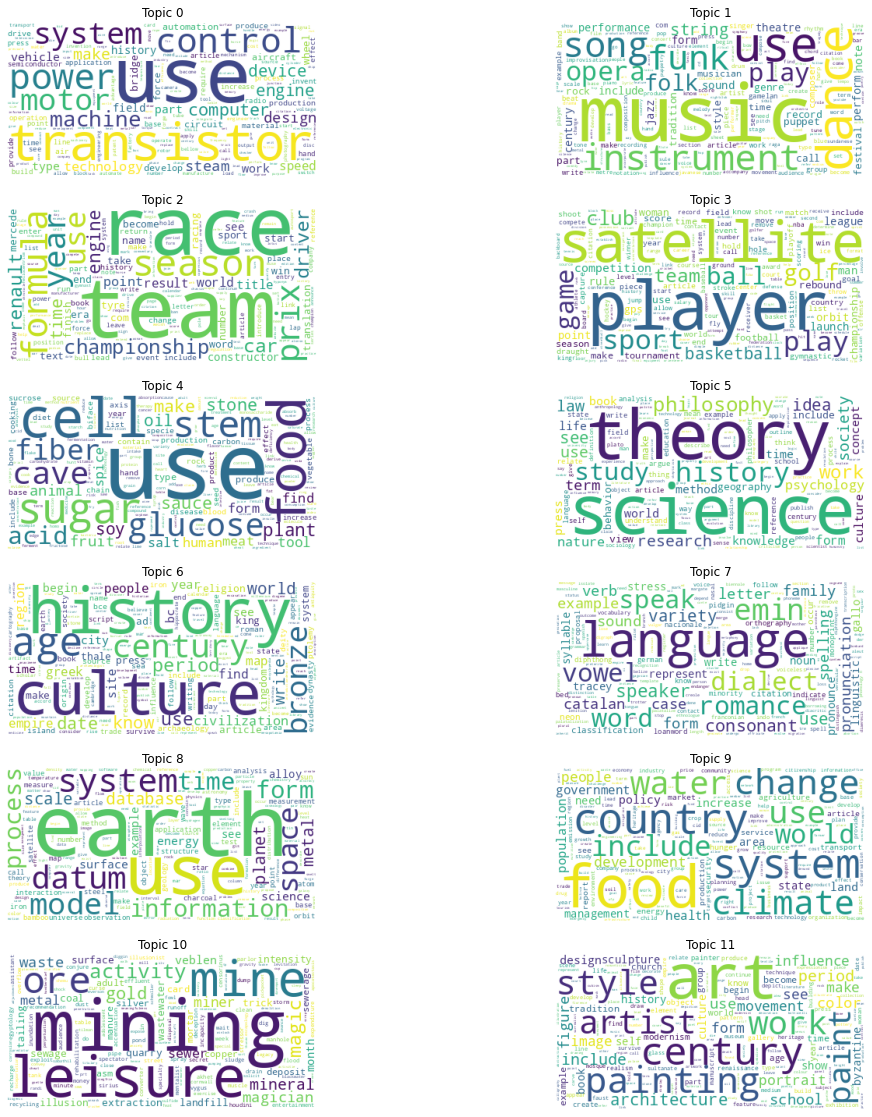

In [27]:
plot_cloud(best_model, export=False)

## Clasificación de tópicos
Se revisaron los tópicos obtenidos en el mejor modelo y se buscó hacerles sentido. Con esto llegamos a los siguientes temas por tópico

In [69]:
topic_class = {
    0: 'Ingeniería',
    1: 'Música',
    2: 'Fórmula 1',
    3: 'Deportes',
    4: 'Comida y Salud',
    5: 'Ciencia',
    6: 'Historia y Cultura',
    7: 'Lenguaje',
    8: 'Planeta',
    9: 'Servicios Básicos',
    10: 'Minería',
    11: 'Arte',
}

In [70]:
def print_topics(model, text, topic_class):
    for a in model.predict(text)['topics']:
        print(f'{topic_class[a[0]]}: {a[1]}')

## Sanity check
Aplicar la función de predict a artículos con tópico conocido y verificar qué tan bien clasifica el modelo.
Para esto se buscaron artículos sobre la data de **test** (_estos artículos nunca se utilizaron para entrenar ni validar el modelo_)

### Artíulo de Fórmula 1 y otros Deportes
Se buscó un artículo relacionado a Fórmula 1 y uno a otros deportes debido a que en el modelo se separaron ambos

In [52]:
test[test['topic']=='sports'].head(15)

,topic,title,text
1,sports,F1 (disambiguation),For the Wikipedia F1 criterion for speedy dele...
2,sports,Council of Europe,International organisation founded in 1949. No...
4,sports,Musselburgh Links,". Musselburgh Links, The Old Golf CourseOld St..."
10,sports,Formula One racing,Overview explanation of what constitutes a For...
12,sports,Chovgan,"Horse-riding game. ""Chowgan"" redirects here. F..."
15,sports,Open-wheel car,Type of automobile. This article needs additio...
17,sports,Tournament,Sports event with a number of teams. This arti...
21,sports,Ball game,Game or sport featuring a ball as part of play...
44,sports,Formula One car,Class of formula race car. For a summary of th...
45,sports,Golf (disambiguation),". Look up golf in Wiktionary, the free diction..."


Fórmula 1

In [38]:
article = test[test['topic']=='sports'].iloc[3].text
print(f"Titulo: {test[test['topic']=='sports'].iloc[3].title}")
print(f"Articulo: {article}")

Titulo: Formula One racing
Articulo: Overview explanation of what constitutes a Formula One Grand Prix motor racing event. This article is about the racing events specifically. For a general overview of the sport, see Formula One. Formula One. Current season. 2022 Formula One World Championship. Related articles. History of Formula One. Formula One racing. Formula One regulations. Formula One cars. Formula One engines. Formula One tyres. Lists. Drivers (GP winnersPolesittersFastest laps ChampionsNumbers). Constructors (GP winnersChampions). Engine manufacturers (GP winnersChampions). SeasonsGrands PrixCircuits. Race Promoters' Trophy winners. Points scoring systems. National coloursSponsorship liveries. Racing flagsRed-flagged races. Female driversTV broadcasters. FatalitiesVideo games. Records. Drivers. Constructors. Engines. Tyres. Races. Organisations. FIA. FIA World Motor Sport Council. Formula One Group. Liberty Media. Formula One Constructors' Association. Formula One Teams Assoc

In [39]:
print_topics(best_model, article, topic_class)

2022-07-14 09:24:07.120414    sentences_as_words
2022-07-14 09:24:07.137316    remove_stopwords
2022-07-14 09:24:07.138204    lemmatization
Fórmula 1: 0.8909246325492859
Deportes: 0.0702599510550499
Clima y Agricultura: 0.012033701874315739


Artículo de otros deportes

In [48]:
article = test[test['topic']=='sports'].iloc[7].text
print(f"Titulo: {test[test['topic']=='sports'].iloc[7].title}")
print(f"Articulo: {article}")

Titulo: Ball game
Articulo: Game or sport featuring a ball as part of playThis article does not cite any sources. Please help improve this article by adding citations to reliable sources. Unsourced material may be challenged and removed. Find sources: "Ball game" – news · newspapers · books · scholar · JSTOR (January 2021) (Learn how and when to remove this template message). Ball games (or ballgames), also ball sports, are any form of game or sport which feature a ball as part of play. These include games such as football, cricket, baseball, basketball, and American football. Such games have diverse rules and histories and are of mostly unrelated origins. Ball games can be defined in several broad types, and generally try to measure how well a player can hit a ball:. bat-and-ball games, such as cricket and baseball. These measure the quality of a hit by looking at how much running a ball-hitting player can accomplish before an opponent can retrieve the ball. Racquet and ball games, su

In [49]:
print_topics(best_model, article, topic_class)

2022-07-14 09:32:24.383771    sentences_as_words
2022-07-14 09:32:24.385547    remove_stopwords
2022-07-14 09:32:24.385692    lemmatization
Tecnología: 0.1301468014717102
Deportes: 0.8028465509414673
Comida y Salud: 0.012154894880950451
Planeta: 0.05125892162322998


### Artículo de Música

In [51]:
test[test['topic']=='music'].head(15)

,topic,title,text
0,music,Pitch (music),Perceptual property in music ordering sounds f...
9,music,Music of China,Cultural musical history. Music of China. Time...
19,music,List of islands of Indonesia,. This article needs additional citations for ...
24,music,Polyhymnia,Muse of sacred poetry in Greek mythology. Poly...
32,music,Ventriloquism,"Ability to throw one's voice. For other uses, ..."
48,music,Music of Greece,This article needs additional citations for ve...
53,music,Black MIDI,This article is about the music genre. For the...
68,music,Dhikr,Repetition of short phrases or prayers in Isla...
70,music,Cilappatikaram,Ancient Tamil Hindu–Jain epic. Topics in Tamil...
78,music,Voyager Golden Record,Two phonograph records included on both Voyage...


In [53]:
article = test[test['topic']=='music'].iloc[13].text
print(f"Titulo: {test[test['topic']=='music'].iloc[13].title}")
print(f"Articulo: {article}")

Titulo: Dynamics (music)
Articulo: Volume of a sound or note. "Fortissimo" and "Pianissimo" redirect here. For other uses, see Fortissimo (disambiguation) and Pianissimo (disambiguation). The beginning of the principal theme to the third movement of Berlioz's Symphonie fantastique showing examples of pianissimo (pp) and hairpins. In music, the dynamics of a piece is the variation in loudness between notes or phrases. Dynamics are indicated by specific musical notation, often in some detail. However, dynamics markings still require interpretation by the performer depending on the musical context: for instance, the forte marking f (meaning loud) in one part of a piece might have quite different objective loudness in another piece or even a different section of the same piece. The execution of dynamics also extends beyond loudness to include changes in timbre and sometimes tempo rubato. Contents. 1 Purpose and interpretation. 2 Dynamic markings. 2. 1 Changes. 2. 2 Extreme dynamic markings

In [55]:
print_topics(best_model, article, topic_class)

2022-07-14 09:35:42.378185    sentences_as_words
2022-07-14 09:35:42.393807    remove_stopwords
2022-07-14 09:35:42.394535    lemmatization
Tecnología: 0.026689160615205765
Música: 0.7686190009117126
Fórmula 1: 0.06147504970431328
Ciencia: 0.04221712797880173
Planeta: 0.07742182910442352
Clima y Agricultura: 0.020504334941506386


### Artículo de ciencia

In [57]:
test[test['topic']=='science'].head(15)

,topic,title,text
3,science,Ethology,"Not to be confused with ethics, ethnology, eti..."
7,science,History of science,History of the development of science. For the...
14,science,On the Connexion of the Physical Sciences,"Book by Mary Somerville, written in 1834. On t..."
26,science,Participle,Form of a verb which is used in a sentence to ...
31,science,Back-formation,Creating a word by removing actual or supposed...
49,science,Science (disambiguation),". Look up science in Wiktionary, the free dict..."
50,science,Testability,This article includes a list of general refere...
76,science,Socratic method,Type of cooperative argumentative dialogue. Pa...
92,science,Weapon,"""Weaponry"" redirects here. For the radio progr..."
105,science,William Whewell,19th-century English scientist and theologian....


In [58]:
article = test[test['topic']=='science'].iloc[5].text
print(f"Titulo: {test[test['topic']=='science'].iloc[5].title}")
print(f"Articulo: {article}")

Titulo: Science (disambiguation)
Articulo: . Look up science in Wiktionary, the free dictionary. Science is a systematic enterprise for obtaining knowledge through testable explanations and predictions. Science may also refer to:. Contents. 1 Branches. 2 Literature. 3 Music. 4 Other uses. 5 See also. Branches. Natural science, the use of the scientific method to study the universe. Social science, the use of the scientific method to study society. Formal science, the study of rules, logic, and formal systems of information. Applied science, the study of technology. Mathematical science, the study of mathematical nature. Literature. Science (journal), the academic journal of the American Association for the Advancement of Science. Science (1979–1986 magazine), a general science magazine published by the AAAS as Science 80, merged into Discover. The Sciences, a popular science magazine published by the New York Academy of Sciences from 1961 to 2001. Music. S. C. I. E. N. C. E. , a 1997 a

In [59]:
print_topics(best_model, article, topic_class)

2022-07-14 09:39:05.667581    sentences_as_words
2022-07-14 09:39:05.669668    remove_stopwords
2022-07-14 09:39:05.669802    lemmatization
Tecnología: 0.06318704038858414
Música: 0.16326260566711426
Comida y Salud: 0.01285234373062849
Ciencia: 0.755768358707428


### Artículo de Arte

In [73]:
test[test['topic']=='art'].head(15)

,topic,title,text
11,art,Great Mosque of Kairouan,Tunisian religious building and site of Islami...
20,art,Concept,Mental representation or an abstract object. F...
23,art,Harmony,"Aspect of music. For other uses, see Harmony (..."
25,art,Principles of grouping,Perception. This article needs additional cita...
34,art,Ion (dialogue),Part of a series onPlatonismPlato from Raphael...
35,art,Etymology,"Study of the history of the forms of words. ""E..."
42,art,Performing arts,Art forms in which the body is used to convey ...
52,art,Immanuel Kant,"German philosopher (1724–1804)""Kant"" redirects..."
57,art,Damien Hirst,English artist. Damien HirstHirst in a still f...
58,art,Contemporary art,Art of the present time. Not to be confused wi...


In [74]:
article = test[test['topic']=='art'].iloc[9].text
print(f"Titulo: {test[test['topic']=='art'].iloc[9].title}")
print(f"Articulo: {article}")

Titulo: Contemporary art
Articulo: Art of the present time. Not to be confused with Modern art. Contemporary artDona i Ocell, by Joan MiróRose, by Isa Genzken. History of art. Periods. Prehistoric. Ancient. Medieval. Renaissance. Baroque. Rococo. Neoclassicism. Revivalism. Romanticism. Realism. Modern. Postmodern. Contemporary. RegionsArt of the Middle East. Mesopotamian. Egyptian. Hittite. Persian. Arabian. South Arabian. Phoenician. Ottoman. Art of Asia. Indian. Chinese. Central Asian. Japanese. Korean. Singaporean. Newa. Bhutanese. Tibetan. Vietnamese. Thai. Cambodian. Khmer. Indonesian. Filipino. Art of Europe. Minoan. Cycladic. Etruscan. Dacian. Celtic. Scythian. Greek. Hellenistic. Iberian. Roman. Byzantine. Anglo-Saxon. Ottonian. Viking. Romanesque. Gothic. Rus. Renaissance. Mannerism. Baroque. Rococo. Neoclassicism. Romanticism. Realism. Impressionism. Symbolism. Decorative. Post-Impressionism. Art Nouveau. Fauvism. Expressionism. Cubism. Pop. Art of Africa. Igbo. Yoruba. Benin

In [75]:
print_topics(best_model, article, topic_class)

2022-07-14 13:26:03.829634    sentences_as_words
2022-07-14 13:26:03.850157    remove_stopwords
2022-07-14 13:26:03.851461    lemmatization
Música: 0.010030384175479412
Ciencia: 0.14035473763942719
Servicios Básicos: 0.04538002982735634
Arte: 0.7949000597000122


### Artículo de Tecnología

In [76]:
test[test['topic']=='technology'].head(15)

,topic,title,text
5,technology,Neolithic Revolution,Transition from hunter-gatherer to settled peo...
6,technology,Tool,"For other uses, see Tool (disambiguation) and ..."
28,technology,Final good,Commodity which is produced and subsequently c...
47,technology,Metallurgical furnace,Device used to heat and munipuliate metals. In...
59,technology,Pre-modern human migration,This article focusses on prehistorical migrati...
66,technology,Artificial general intelligence,Hypothetical human-level or stronger AI. Part ...
73,technology,Tigris,"River in Turkey, Iraq, and Syria. For other us..."
89,technology,Uruk,"Ancient city of Sumer and Babylonia. ""Erech"" r..."
90,technology,Manufacturing,Industrial activity producing goods for sale u...
103,technology,Crete,Largest Greek island. This article is about th...


In [79]:
article = test[test['topic']=='technology'].iloc[5].text
print(f"Titulo: {test[test['topic']=='technology'].iloc[5].title}")
print(f"Articulo: {article}")

Titulo: Artificial general intelligence
Articulo: Hypothetical human-level or stronger AI. Part of a series onArtificial intelligence. Major goals. Artificial general intelligence. Planning. Computer vision. General game playing. Knowledge reasoning. Machine learning. Natural language processing. Robotics. Approaches. Symbolic. Deep learning. Bayesian networks. Evolutionary algorithms. Philosophy. Chinese room. Friendly AI. Control problem/Takeover. Ethics. Existential risk. Turing test. History. Timeline. Progress. AI winter. Technology. Applications. Projects. Programming languages. Glossary. Glossary. vte. Artificial general intelligence (AGI) is the ability of an intelligent agent to understand or learn any intellectual task that a human being can. It is a primary goal of some artificial intelligence research and a common topic in science fiction and futures studies. AGI can also be referred to as strong AI, full AI, or general intelligent action, although some academic sources res

In [80]:
print_topics(best_model, article, topic_class)

2022-07-14 13:30:17.011767    sentences_as_words
2022-07-14 13:30:17.053117    remove_stopwords
2022-07-14 13:30:17.055184    lemmatization
Ingeniería: 0.1121690571308136
Ciencia: 0.6435783505439758
Planeta: 0.10064803063869476
Servicios Básicos: 0.11727173626422882


## Análisis de Resultados

De la tabla de resumen de ejecución del modelo pudimos sacar las siguientes conclusiones:
- Se puede observar que la métrica de coherencia para los datos de entrenamiento vs validación vs prueba son bastante similares, por lo que se puede concluir que el modelo está generalizando bastante bien
- A diferencia de la tarea anterior de análisis de sentimiento, donde funcionaron mejor los modelos que únicamente lematizaban, para estos modelos se obtuvo mejor resultado al lematizar después de aplicar stopwords
- Calcular NGrams disminuye el performance de los modelos. Al igual que calcular modelos que utilizan solo NGrams en el pipeline de preprocesamiento, ya que fueron los de menor performance por mucho. 
- Scrapeamos información de 8 tópicos. Sin embargo, nos hizo sentido que el modelo que mejor coherencia nos entregó obtuviera 12 tópicos, ya que notamos que al extraer la información de wikipedia habían varios artículos que podían clasificarse en más de un tópico. Por ejemplo, notamos que separó todo lo relacionado a Fórmula 1 y el resto de deportes, lo cual hace bastante sentido.
- Para la lematización consideramos que nos funcionó bien el incluir únicamente NOUN y VERB como `alloweb_postags` (quitando ADV, ADJ y PART que consideramos que no agregaban valor a los temas)
- Se notó una relación de la coherencia con la cantidad de tópicos del modelo. A mayor cantidad de tópicos se obtuvo una mejor coherencia. Se puede observar que los modelos entrenados con 4, 5 y 6 tópicos por lo general tuvieron menor performance.
- La cantidad de `passes` también se correlacionó positivamente con la coherencia del modelo
- Nos vimos en la necesidad de extender las stopwords para limpiar algunos tokens que no quedaron del todo bien en el proceso de extracción de información de wikipedia. Palabras `isbn`, `pmid` o `retrieve` vimos que nos agregaban ruido en los wordclouds de los modelos, por lo que decidimos excluirlas en todos los entrenamientos
- En el sanity check podemos observar que en todos los casos clasificó bastante satisfactorio el artículo, por lo que consideramos que el modelo funcionó bastante bien con datos con los que no fue entrenado.